In [ ]:
import numpy as np
import pandas as pd
from keras import backend as K
import gensim
from numpy import *
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train_temp = pd.read_csv('/content/drive/My Drive/train_data_short.csv')
df_test_temp = pd.read_csv('/content/drive/My Drive/test_data_short.csv')
df_val_temp = pd.read_csv('/content/drive/My Drive/val_data_short.csv')


In [ ]:
# df_val_compressed.drop(['id'],axis=1,inplace=True)
# df_val_compressed.rename(columns={"highlights":"summary"},inplace=True)
# df_val_compressed

,article,summary
0,A bird that was long thought to have gone extinct has been rediscovered in Burma after a team of scientists used a recording of the species' distinctive call to track it down. The Jerdon's Babbler...,"Was last spotted in Burma in 1941,and was thought to have died out .\nScientists used a recording of its distinctive call to rediscover species .\nDiscovery proves bird and habitat both still exis..."
1,"A Sydney pastor has spoken about the incredible moment Bali Nine ringleader Andrew Chan offered a vital piece of himself in a bid to save the man's life. Mal Feebrey, a men's mental health ambassa...","Pastor Mal Feebrey discovered he had terminal liver disease in 2010 .\nHe had developed a close friendship with Bali Nine kingpin Andrew Chan .\nWhen Chan learnt of his condition, he immediately o..."
2,Everton boss Roberto Martinez feels the poor condition of the pitch at Dynamo Kiev's Olympic Stadium is 'a concern' - but he is sure it will be just as problematic for one side as the other in Thu...,Everton take on Dynamo Kiev in the Europa League last 16 .\nThe Toffees currently lead the tie 2-1 on aggregate .\nMartinez says the poor condition of the pitch will cause problems .
3,The so-called ‘health tourism gap’ between the amount the NHS collects from EU patients and the total hospitals on the continent receive from Britain has soared to almost £700million (file picture...,Hospitals still failing to claw back the cost of treating Europeans on NHS .\nComes as the health tourism gap soars to almost £700million a year .\nUK now pays £15 for healthcare costs for Britons...
4,North Carolina State University disbanded a fraternity chapter Wednesday following the discovery of a notebook filled with sexist and racially offensive entries in a restaurant off campus. The pun...,North Carolina State University has disbanded its Pi Kappa Phi chapter .\nBook with 'reprehensible' quotes found near school's campus in Raleigh .\nSchool suspended social events with alcohol at m...
...,...,...
1332,"A little boy born with a rare brain disease that prevented him from being able to cry or feed properly, has died at just eight weeks old. Yasmin and Michael Burley have shared a touching tribute t...","Tate Burley was born with Miller Dieker Lissencephaly and died at 8 weeks .\nThe syndrome, a rare defect of the brain, meant he couldn't cry or eat properly and would not have lived past five-year..."
1333,"Tony Abbott has pleaded with Labor to back legislation to crack down on illegal firearms, which will be reintroduced to parliament this week. The coalition will again push for a mandatory five-yea...",Tony Abbott has pleaded with Labor to back a new gun legislation .\nThe coalition is pushing for a five-year minimum sentence for traffickers .\nIt will be introduced into parliament this week .\n...
1334,Milos Raonic gatecrashed a party seemingly reserved for the best four players in the world by shocking Rafael Nadal in the quarter-finals of the BNP Paribas Open. World number one Novak Djokovic a...,Milos Raonic beat Rafael Nadal 4-6 7-6 (12/10) 7-5 at Indian Wells .\nCanadian sixth seed reaches the semi-finals of the BNP Paribas Open .\nRaonic served 19 aces and saved six break points in the...
1335,"(CNN)Vin Diesel has been paying tribute to his friend Paul Walker as fans eagerly await the release of ""Furious 7."" On Monday, he revealed a very personal way that he has remembered Walker: by nam...","Diesel named his daughter Pauline after Walker .\nDiesel calls ""Furious 7"" a ""very personal film""\nCo-star Walker was killed in 2013 during break in filming .\nThe seventh ""Fast and Furious"" film ..."


In [ ]:
# df_train_temp = df_train_compressed.sample(frac=0.33, random_state=42)
# df_test_temp = df_test_compressed.sample(frac=0.1, random_state=42)
# df_val_temp = df_val_compressed.sample(frac=0.1, random_state=42)

In [ ]:
df_train_temp['summary'] = df_train_temp['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_val_temp['summary'] = df_val_temp['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_test_temp['summary'] = df_test_temp['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
df_train_temp.shape

(9475, 2)

In [ ]:
cnt=0
for i in df_train_temp['summary']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(df_train_temp['summary']))

0.9683377308707124


In [ ]:
cnt=0
for i in df_train_temp['article']:
    if(len(i.split())<=512):
        cnt=cnt+1
print(cnt/len(df_train_temp['article']))

0.3482849604221636


In [ ]:
max_article_len=512
max_summary_len=100

In [ ]:
#Select the Summaries and Text between max len defined above from train data

cleaned_text =np.array(df_train_temp['article'])
cleaned_summary=np.array(df_train_temp['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_article_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_train_short=pd.DataFrame({'article':short_text,'summary':short_summary})

In [ ]:
#Select the Summaries and Text between max len defined above from train data

cleaned_text =np.array(df_val_temp['article'])
cleaned_summary=np.array(df_val_temp['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_article_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_val_short=pd.DataFrame({'article':short_text,'summary':short_summary})

In [ ]:
#Select the Summaries and Text between max len defined above from test data

cleaned_text =np.array(df_test_temp['article'])
cleaned_summary=np.array(df_test_temp['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_article_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_test_short=pd.DataFrame({'article':short_text,'summary':short_summary})

In [ ]:
x_train, y_train = df_train_short['article'],df_train_short['summary']
x_val, y_val = df_val_short['article'], df_val_short['summary']
x_test, y_test = df_test_short['article'],df_test_short['summary']

In [ ]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (3607,)
Shape of y_train: (3607,)
Shape of x_val: (450,)
Shape of y_val: (450,)
Shape of x_test: (451,)
Shape of y_test: (451,)


In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 69.15435959426078
Total Coverage of rare words: 8.974735673676502


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_train)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq    =   x_tokenizer.texts_to_sequences(x_test)


#padding zero upto maximum length
x_train    =   pad_sequences(x_tr_seq,  maxlen=max_article_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_article_len, padding='post')
x_test   =   pad_sequences(x_val_seq, maxlen=max_article_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 5870


In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 87.08237848269208
Total Coverage of rare words: 29.18855105285983


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)



#padding zero upto maximum length
y_train    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')


#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 1072


In [ ]:
K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_article_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 200)             1174000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 100, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [ ]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/30
29/29 [==============================] - 49s 1s/step - loss: 4.0274 - val_loss: 3.0280
Epoch 2/30
29/29 [==============================] - 37s 1s/step - loss: 3.1489 - val_loss: 2.8744
Epoch 3/30
29/29 [==============================] - 35s 1s/step - loss: 3.0735 - val_loss: 2.7610
Epoch 4/30
29/29 [==============================] - 35s 1s/step - loss: 2.9600 - val_loss: 2.6682
Epoch 5/30
29/29 [==============================] - 35s 1s/step - loss: 2.8781 - val_loss: 2.6193
Epoch 6/30
29/29 [==============================] - 34s 1s/step - loss: 2.8466 - val_loss: 2.6137
Epoch 7/30
29/29 [==============================] - 34s 1s/step - loss: 2.8329 - val_loss: 2.6237
Epoch 8/30
29/29 [==============================] - 35s 1s/step - loss: 2.8255 - val_loss: 2.6070
Epoch 9/30
29/29 [==============================] - 35s 1s/step - loss: 2.8193 - val_loss: 2.6036
Epoch 10/30
29/29 [==============================] - 36s 1s/step - loss: 2.8162 - val_loss: 2.5915
Epoch 11/30
29/29 [

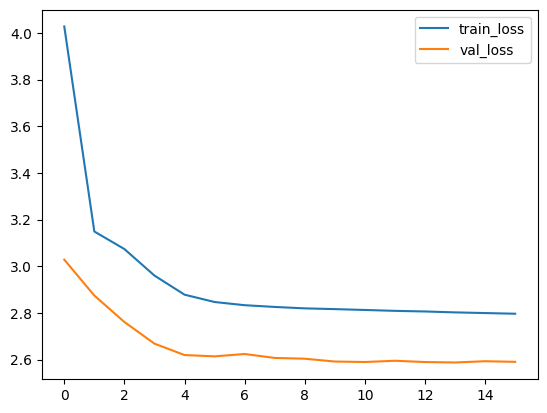

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_article_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:

# Assuming you have a DataFrame called df_train
# Assuming you have functions seq2text, seq2summary, and decode_sequence defined

# Create a new DataFrame to store predicted summaries
df_predicted = pd.DataFrame(columns=['Review', 'Original Summary', 'Predicted Summary'])

# Iterate through the data and add predictions to the new DataFrame
for i in range(500):
    review = seq2text(x_train[i])
    original_summary = seq2summary(y_train[i])
    predicted_summary = decode_sequence(x_train[i].reshape(1, max_article_len))

    df_predicted = df_predicted.append({
        'Review': review,
        'Original Summary': original_summary,
        'Predicted Summary': predicted_summary
    }, ignore_index=True)




1/1 [==============================] - 0s 21ms/step


In [ ]:
!pip install rouge_score

In [ ]:
from rouge_score import rouge_scorer

# Assuming df_predicted is your DataFrame with 'Original Summary' and 'Predicted Summary' columns
reference_summaries = df_predicted['Original Summary'].tolist()
generated_summaries = df_predicted['Predicted Summary'].tolist()

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each pair of reference and generated summaries
rouge_scores = {
    'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
    'rougeL': {'precision': [], 'recall': [], 'fmeasure': []},
}

for ref, gen in zip(reference_summaries, generated_summaries):
    scores = scorer.score(ref, gen)

    for metric in ['rouge1', 'rougeL']:
        rouge_scores[metric]['precision'].append(scores[metric].precision)
        rouge_scores[metric]['recall'].append(scores[metric].recall)
        rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

# Calculate average ROUGE scores
average_rouge_scores = {}
for metric in ['rouge1', 'rougeL']:
    average_rouge_scores[metric] = {
        'precision': sum(rouge_scores[metric]['precision']) / len(rouge_scores[metric]['precision']),
        'recall': sum(rouge_scores[metric]['recall']) / len(rouge_scores[metric]['recall']),
        'fmeasure': sum(rouge_scores[metric]['fmeasure']) / len(rouge_scores[metric]['fmeasure']),
    }

# Print or use the average ROUGE scores as needed
print("Average ROUGE Scores:")
for metric in ['rouge1', 'rougeL']:
    print(f"{metric}:")
    print(f"  Precision: {average_rouge_scores[metric]['precision']:.4f}")
    print(f"  Recall: {average_rouge_scores[metric]['recall']:.4f}")
    print(f"  F-Measure: {average_rouge_scores[metric]['fmeasure']:.4f}")


Average ROUGE Scores:
rouge1:
  Precision: 0.1320
  Recall: 0.0894
  F-Measure: 0.1020
rougeL:
  Precision: 0.1305
  Recall: 0.0885
  F-Measure: 0.1009
